# 📌 ADIA Lab Structural Break Challenge  

**Assalam o Alaikum👋**  
In this notebook, we are going to explore the concept of **structural breaks (regime shifts)** – basically jab data ka trend, mean, or variance suddenly change ho jaye 📊.  

Structural break detection is an important problem because real-world data kabhi bhi smooth aur stable nahi hota. Kabhi kabhi beech me major shifts aate hain jo forecasting aur analysis dono ko effect kar dete hain.  

---

## 🔎 Challenge Overview  

Welcome to the **ADIA Lab Structural Break Challenge!**  
In this competition, you will analyze **univariate time series data** to determine whether a **structural break** has occurred at a specified boundary point.  

### 📖 What is a Structural Break?  

A **structural break** occurs when the process governing the data generation changes at a certain point in time.  
These changes can be subtle or dramatic, and detecting them accurately is crucial across domains:  

- 🌦 **Climatology** → shifts in long-term weather patterns  
- 🏭 **Industrial Monitoring** → detecting sudden machine behavior changes  
- 💹 **Finance** → market crashes or regime shifts  
- 🏥 **Healthcare** → sudden change in patient health indicators  

![Structural Break Example](https://raw.githubusercontent.com/crunchdao/competitions/refs/heads/master/competitions/structural-break/quickstarters/baseline/images/example.png)  

---

## 📝 Our Task  

For each time series in the **test set**, we need to predict a **score between `0` and `1`:**  

- `0` → No structural break at the specified boundary point  
- `1` → A structural break **did occur**  

---

## 📊 Evaluation Metric  

The challenge uses **ROC AUC (Area Under the Receiver Operating Characteristic Curve)** as the evaluation metric:  

- **ROC AUC ≈ 0.5** → No better than random guessing  
- **ROC AUC → 1.0** → Perfect detection performance  

More about ROC AUC: [sklearn.metrics.roc_auc_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html)  

---

## 📂 Notebook Flow 🚀  

1. **Exploratory Data Analysis (EDA)** – visualize aur samajhenge dataset.  
2. **Methods** – different techniques (statistical + ML-based) try karenge for break detection.  
3. **Evaluation** – compare karenge results aur dekhenge kaun sa method best perform karta hai.  

---

⚡ **Goal**: A clean, reproducible, and easy-to-follow Kaggle-style notebook – jahan beginner bhi seekh le aur advanced banda bhi enjoy kare.  

**Chalo shuru karte hain 🚀**  


In [1]:
# import Important Libraries

!pip install antropy --quiet
!pip install PyWavelets --quiet


In [2]:
import os
import typing

# Import your dependencies
import joblib
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import sklearn.metrics
from scipy.stats import wasserstein_distance  # 1D Earth Mover's Distance
from scipy.stats import skew, kurtosis, ks_2samp
from scipy.stats import wasserstein_distance
from sklearn.model_selection import cross_val_score


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, classification_report, RocCurveDisplay
from scipy.stats import skew, kurtosis, ks_2samp, mannwhitneyu, wasserstein_distance
from scipy.signal import welch, hilbert
from statsmodels.tsa.stattools import acf, pacf

from scipy.signal import welch
import warnings
from sklearn.exceptions import ConvergenceWarning

# Ignore UserWarning
warnings.filterwarnings("ignore", category=UserWarning)

# Ignore ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

### Crunch CLI SETUP

In [3]:
### CRunch CLI Setup
%pip install crunch-cli --upgrade --quiet --progress-bar off
!crunch setup-notebook structural-break yoeieMY9ejPU0bsxWxOCiK5A

import crunch

# Load the Crunch Toolings
crunch = crunch.load_notebook()

# Load the data simply
X_train, y_train, X_test = crunch.load_data()

Note: you may need to restart the kernel to use updated packages.
crunch-cli, version 7.5.0
main.py: download from https:crunchdao--competition--production.s3-accelerate.amazonaws.com/submissions/29908/main.py (18776 bytes)
notebook.ipynb: download from https:crunchdao--competition--production.s3-accelerate.amazonaws.com/submissions/29908/notebook.ipynb (102836 bytes)
requirements.txt: download from https:crunchdao--competition--production.s3-accelerate.amazonaws.com/submissions/29908/requirements.original.txt (249 bytes)
data/X_train.parquet: download from https:crunchdao--competition--production.s3-accelerate.amazonaws.com/data-releases/146/X_train.parquet (204327238 bytes)
data/X_test.reduced.parquet: download from https:crunchdao--competition--production.s3-accelerate.amazonaws.com/data-releases/146/X_test.reduced.parquet (2380918 bytes)
data/y_train.parquet: download from https:crunchdao--competition--production.s3-accelerate.amazonaws.com/data-releases/146/y_train.parquet (61003 

### BASIC EDA

In [4]:
# --- Dataset Overview ---
print("📂 Total training subsequences:", len(X_train))
print(X_train.shape)
print("📂 Total test subsequences:", len(X_test))
print("📂 y_train length:", len(y_train))

# --- Target Labels ---
print("\n📊 y_train distribution:")
print(y_train.value_counts(normalize=True))
print(y_train.value_counts())

# --- Check Nulls in y_train ---
print("\n📉 Missing values in y_train:", y_train.isnull().sum())

# --- Test set EDA (corrected) ---
print("\n📂 Test set overview:")
print("Number of test series:", len(X_test))
print("Shape of first 5 test series:", [np.array(df).shape for df in X_test[:5]])

# --- Nulls in X_train (safe) ---
train_nulls = 0
for x in X_train[:1000]:  # sample 1000 series
    try:
        arr = np.array(x, dtype=float)
        train_nulls += np.isnan(arr).sum()
    except:
        # non-numeric series
        train_nulls += 0

print(f"\n📉 Null values in first 1000 training series: {train_nulls}")

# --- Nulls in X_test (safe) ---
test_nulls = 0
for x in X_test:
    try:
        arr = np.array(x, dtype=float)
        test_nulls += np.isnan(arr).sum()
    except:
        test_nulls += 0

print(f"📉 Null values in test series: {test_nulls}")

# --- Example lengths of sequences ---
train_lengths = [len(x) for x in X_train[:1000]]  # sample
print(f"\n📏 Training series length stats (sample 1000):")
print("Number of datasets:", len(X_test))
print(pd.Series(train_lengths).describe())

📂 Total training subsequences: 23715734
(23715734, 2)
📂 Total test subsequences: 101
📂 y_train length: 10001

📊 y_train distribution:
structural_breakpoint
False    0.709129
True     0.290871
Name: proportion, dtype: float64
structural_breakpoint
False    7092
True     2909
Name: count, dtype: int64

📉 Missing values in y_train: 0

📂 Test set overview:
Number of test series: 101
Shape of first 5 test series: [(2779, 2), (1966, 2), (1775, 2), (3296, 2), (1995, 2)]

📉 Null values in first 1000 training series: 0
📉 Null values in test series: 0

📏 Training series length stats (sample 1000):
Number of datasets: 101
count    2.000000
mean     5.500000
std      0.707107
min      5.000000
25%      5.250000
50%      5.500000
75%      5.750000
max      6.000000
dtype: float64


## 📝 Basic EDA Notes (Updated)

- **Total Training Subsequences:** 23,715,734  
- **Total Test Subsequences:** 101  
- **y_train Length:** 10,001  

### 📊 y_train Distribution
- **Proportion:**  
  - False: 70.9%  
  - True: 29.1%  
- **Counts:**  
  - False: 7,092  
  - True: 2,909  
- Label imbalance exists → metric ROC AUC is robust to this.

### 📉 Missing Values
- **y_train:** 0  
- **X_train (first 1000 series):** 0  
- **X_test:** 0  
- No missing data → preprocessing easier.

### 📂 Test Set Overview
- Number of test series: 101  
- Shape of first 5 test series: `(2779,2), (1966,2), (1775,2), (3296,2), (1995,2)`  
- Each test series has variable length but 2 columns (probably period & value).

### 📏 Training Series Lengths (Sample 1000)
- Min: 5, Max: 6, Mean: 5.5  
- Mostly very short sequences → statistical/ML models will work on small windows.

**Notes:**  
- Dataset has **very large number of training subsequences**  
- No missing values → safe to use directly  
- Label imbalance is moderate → consider for evaluation metric  
- Next steps: visualize sample series, inspect True vs False structural breaks.


### 🔥 Feature Pipeline Structure (According to SHAP and correlation analysis ) in previous notebook

In [5]:
from scipy.stats import skew, kurtosis, ks_2samp, wasserstein_distance, linregress
from scipy.signal import hilbert, welch
from statsmodels.tsa.stattools import acf
import numpy as np
import pandas as pd
import antropy as ant
import pywt

# ---- Helper Functions ----
def robust_stats(arr):
    return {
        'mean': float(np.nanmean(arr)),
        'median': float(np.nanmedian(arr)),
        'std': float(np.nanstd(arr)),
        'iqr': float(np.nanpercentile(arr, 75) - np.nanpercentile(arr, 25))
    }

def slope_feature(x):
    try:
        slope, _, _, _, _ = linregress(range(len(x)), x)
        return float(slope)
    except:
        return np.nan

def fft_features(x):
    try:
        fft_vals = np.abs(np.fft.rfft(x))
        if len(fft_vals) == 0:
            return np.nan, np.nan, np.nan
        return float(np.max(fft_vals)), float(np.mean(fft_vals)), int(np.argmax(fft_vals))
    except:
        return np.nan, np.nan, np.nan

def spectral_features(x, fs=1.0):
    nperseg = min(256, max(8, len(x)))
    f, Pxx = welch(x, fs=fs, nperseg=nperseg)
    try:
        se = float(ant.spectral_entropy(x, sf=fs, method='welch', normalize=True))
    except:
        P = Pxx / (Pxx.sum() + 1e-12)
        se = float(-np.sum(P * np.log(P + 1e-12)))
    centroid = float(np.sum(f * Pxx) / (np.sum(Pxx) + 1e-12))
    return se, centroid

def hilbert_features(x):
    try:
        analytic = hilbert(x)
        amp_env = np.abs(analytic)
        return float(np.mean(amp_env)), float(np.std(amp_env))
    except:
        return np.nan, np.nan

def compute_permutation_entropy(x, m=3, tau=1):
    try:
        return float(ant.perm_entropy(x, order=m, delay=tau, normalize=True))
    except:
        return np.nan

def compute_multiscale_entropy(x, scales=(2,3,5)):
    vals = []
    for s in scales:
        xs = x[::s]
        if len(xs) > 10:
            try:
                vals.append(float(ant.sample_entropy(xs)))
            except:
                pass
    return float(np.mean(vals)) if vals else np.nan

def lz_complexity(x):
    try:
        sig = np.sign(x - np.nanmean(x)).astype(int)
        return float(ant.lziv_complexity(sig))
    except:
        return np.nan

# ---- Main Feature Builder ----# -

def build_selected_features(X_df, y_series):
    rows, ids = [], []

    for sid, df in X_df.groupby(level='id', sort=False):
        df = df.dropna(subset=['value'])
        before = df.loc[df['period']==0, 'value'].to_numpy(dtype=float)
        after  = df.loc[df['period']==1, 'value'].to_numpy(dtype=float)

        if len(before) < 8 or len(after) < 8:
            continue

        b = robust_stats(before)
        a = robust_stats(after)

        feats = {
            # basic stats
            'b_mean': b['mean'], 'a_mean': a['mean'],
            'b_median': b['median'], 'a_median': a['median'],
            'b_std': b['std'], 'a_std': a['std'],
            'b_iqr': b['iqr'], 'a_iqr': a['iqr'],

            # diffs/ratios
            'mean_diff': a['mean'] - b['mean'],
            'median_diff': a['median'] - b['median'],
            'iqr_diff': a['iqr'] - b['iqr'],
            'std_ratio': (a['std']+1e-9)/(b['std']+1e-9),
        }

        # shape
        feats['skew_diff']  = skew(after) - skew(before)
        feats['kurt_diff']  = kurtosis(after) - kurtosis(before)

        # slope/trend
        feats['slope_diff'] = slope_feature(after) - slope_feature(before)

        # fft/spectral
        max_b, _, peak_b = fft_features(before)
        max_a, _, peak_a = fft_features(after)
        feats['fft_peak_diff'] = max_a - max_b
        feats['fft_domfreq_shift'] = peak_a - peak_b

        se_b, cent_b = spectral_features(before)
        se_a, cent_a = spectral_features(after)
        feats['spectral_entropy_diff'] = se_a - se_b
        feats['spectral_centroid_diff'] = cent_a - cent_b

        # acf
        for lag in [1,2,5,10]:
            try:
                feats[f'acf_lag{lag}_diff'] = acf(after, nlags=lag, fft=True)[lag] - acf(before, nlags=lag, fft=True)[lag]
            except:
                feats[f'acf_lag{lag}_diff'] = np.nan

        # entropy family
        feats['perm_entropy_diff'] = compute_permutation_entropy(after) - compute_permutation_entropy(before)
        feats['ms_entropy_diff']   = compute_multiscale_entropy(after) - compute_multiscale_entropy(before)
        feats['lz_complexity_diff'] = lz_complexity(after) - lz_complexity(before)

        # distances/tests
        try:
            feats['ks_stat'] = ks_2samp(before, after).statistic
        except:
            feats['ks_stat'] = np.nan
        try:
            feats['wasserstein'] = wasserstein_distance(before, after)
        except:
            feats['wasserstein'] = np.nan

        # hilbert mean only
        hb_mean_b, _ = hilbert_features(before)
        hb_mean_a, _ = hilbert_features(after)
        feats['hilbert_mean_diff'] = hb_mean_a - hb_mean_b

        rows.append(feats)
        ids.append(sid)

    X_features = pd.DataFrame(rows, index=ids)
    X_features.index.name = 'id'
    X_features = X_features.replace([np.inf, -np.inf], np.nan).fillna(0)
    y_features = y_series.loc[X_features.index].astype(int)
    return X_features, y_features


# ---- Single-series extractor ----
def extract_selected_features_series(df):
    df = df.dropna(subset=['value'])
    before = df.loc[df['period']==0, 'value'].to_numpy(dtype=float)
    after  = df.loc[df['period']==1, 'value'].to_numpy(dtype=float)

    if len(before) < 8 or len(after) < 8:
        return None

    b = robust_stats(before)
    a = robust_stats(after)

    feats = {
        # basic stats
        'b_mean': b['mean'], 'a_mean': a['mean'],
        'b_median': b['median'], 'a_median': a['median'],
        'b_std': b['std'], 'a_std': a['std'],
        'b_iqr': b['iqr'], 'a_iqr': a['iqr'],

        # diffs/ratios
        'mean_diff': a['mean'] - b['mean'],
        'median_diff': a['median'] - b['median'],
        'iqr_diff': a['iqr'] - b['iqr'],
        'std_ratio': (a['std']+1e-9)/(b['std']+1e-9),
    }

    # shape
    feats['skew_diff']  = skew(after) - skew(before)
    feats['kurt_diff']  = kurtosis(after) - kurtosis(before)

    # slope/trend
    feats['slope_diff'] = slope_feature(after) - slope_feature(before)

    # fft/spectral
    max_b, _, peak_b = fft_features(before)
    max_a, _, peak_a = fft_features(after)
    feats['fft_peak_diff'] = max_a - max_b
    feats['fft_domfreq_shift'] = peak_a - peak_b

    se_b, cent_b = spectral_features(before)
    se_a, cent_a = spectral_features(after)
    feats['spectral_entropy_diff'] = se_a - se_b
    feats['spectral_centroid_diff'] = cent_a - cent_b

    # acf
    for lag in [1,2,5,10]:
        try:
            feats[f'acf_lag{lag}_diff'] = acf(after, nlags=lag, fft=True)[lag] - acf(before, nlags=lag, fft=True)[lag]
        except:
            feats[f'acf_lag{lag}_diff'] = np.nan

    # entropy family
    feats['perm_entropy_diff'] = compute_permutation_entropy(after) - compute_permutation_entropy(before)
    feats['ms_entropy_diff']   = compute_multiscale_entropy(after) - compute_multiscale_entropy(before)
    feats['lz_complexity_diff'] = lz_complexity(after) - lz_complexity(before)

    # distances/tests
    try:
        feats['ks_stat'] = ks_2samp(before, after).statistic
    except:
        feats['ks_stat'] = np.nan
    try:
        feats['wasserstein'] = wasserstein_distance(before, after)
    except:
        feats['wasserstein'] = np.nan

    # hilbert mean only
    hb_mean_b, _ = hilbert_features(before)
    hb_mean_a, _ = hilbert_features(after)
    feats['hilbert_mean_diff'] = hb_mean_a - hb_mean_b

    return feats


In [6]:
# --- Apply feature engineering to check the impact ---
X_features, y_features = build_selected_features(X_train, y_train)
print(X_features.shape)
print(y_features.value_counts())

(10001, 29)
structural_breakpoint
0    7092
1    2909
Name: count, dtype: int64


In [7]:
X_features.sample()

,b_mean,a_mean,b_median,a_median,b_std,a_std,b_iqr,a_iqr,mean_diff,median_diff,...,acf_lag1_diff,acf_lag2_diff,acf_lag5_diff,acf_lag10_diff,perm_entropy_diff,ms_entropy_diff,lz_complexity_diff,ks_stat,wasserstein,hilbert_mean_diff
id,,,,,,,,,,,,,,,,,,,,,
1426,0.000539,0.00125,-0.005305,-0.003571,0.035535,0.04246,0.035726,0.037016,0.000711,0.001734,...,-0.013203,0.036808,0.033913,-0.059718,0.00775,0.0,-159.0,0.050058,0.004852,0.008024


In [8]:
X_features.isna().sum().sort_values(ascending=False)


b_mean                    0
fft_peak_diff             0
wasserstein               0
ks_stat                   0
lz_complexity_diff        0
ms_entropy_diff           0
perm_entropy_diff         0
acf_lag10_diff            0
acf_lag5_diff             0
acf_lag2_diff             0
acf_lag1_diff             0
spectral_centroid_diff    0
spectral_entropy_diff     0
fft_domfreq_shift         0
slope_diff                0
a_mean                    0
kurt_diff                 0
skew_diff                 0
std_ratio                 0
iqr_diff                  0
median_diff               0
mean_diff                 0
a_iqr                     0
b_iqr                     0
a_std                     0
b_std                     0
a_median                  0
b_median                  0
hilbert_mean_diff         0
dtype: int64

### Model Training And Evaluation

In [9]:
%%writefile main.py



Overwriting main.py


In [10]:

# ======= Refactor-friendly train() and infer() =======
import os
import joblib
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_auc_score
from sklearn.utils.class_weight import compute_sample_weight
import matplotlib.pyplot as plt

def train(X_train: pd.DataFrame, y_train: pd.Series, model_directory_path: str):
    """
    Train stacking model with XGB as meta learner, 7-fold CV, full class imbalance handling.
    """
    os.makedirs(model_directory_path, exist_ok=True)
    rng_seed = 42

    # 1) Feature extraction
    X_features, y_features = build_selected_features(X_train, y_train)
    print(f"[train] Features built: {X_features.shape}, labels: {y_features.value_counts().to_dict()}")

    # 2) Compute positive class ratio for XGB
    neg = len(y_features) - int(y_features.sum())
    pos = int(y_features.sum())
    pos_ratio = neg / (pos + 1e-9)

    # 3) Define base models with full imbalance handling
    base_models = [
        ("xgb_base", xgb.XGBClassifier(
            n_estimators=400, learning_rate=0.05, max_depth=5,
            subsample=0.8, colsample_bytree=0.8,
            eval_metric="logloss", use_label_encoder=False,
            random_state=rng_seed, scale_pos_weight=pos_ratio
        )),
        ("rf", RandomForestClassifier(
            n_estimators=400, max_depth=12, n_jobs=-1,
            random_state=rng_seed, class_weight="balanced"
        )),
        ("hgb", HistGradientBoostingClassifier(
            max_iter=300, max_depth=5, learning_rate=0.05,
            random_state=rng_seed, class_weight="balanced"
        )),
#        ("mlp", Pipeline([
 #           ("scaler", RobustScaler()),
  #          ("mlp", MLPClassifier(hidden_layer_sizes=(128,), max_iter=500, random_state=rng_seed))
   #     ])),
 #       ("logreg", Pipeline([
 #           ("scaler", RobustScaler()),
 #           ("logreg", LogisticRegression(solver="liblinear", class_weight="balanced", random_state=rng_seed))
#]))
    ]

    # 4) Prepare 7-fold GroupKFold
    gkf = GroupKFold(n_splits=7)
    groups = X_features.index
    oof_preds_per_model = {name: np.zeros(len(X_features)) for name, _ in base_models}
    fold_results = pd.DataFrame(columns=[f"fold_{i}" for i in range(1, 8)], index=[name for name, _ in base_models])
    fold_results.index.name = "model"

    calibrated_estimators = []

    # 5) Fit base models with CV and calibration
    for name, model in base_models:
        print(f"[train] CV for base model: {name}")
        fold_preds = np.zeros(len(X_features))
        for fold, (tr_idx, val_idx) in enumerate(gkf.split(X_features, y_features, groups)):
            X_tr, X_val = X_features.iloc[tr_idx], X_features.iloc[val_idx]
            y_tr, y_val = y_features.iloc[tr_idx], y_features.iloc[val_idx]

            # Compute sample_weight for MLP
            if name == "mlp":
                sample_weight = compute_sample_weight(class_weight="balanced", y=y_tr)
                model.fit(X_tr, y_tr, mlp__sample_weight=sample_weight)
            else:
                model.fit(X_tr, y_tr)

            proba = model.predict_proba(X_val)[:, 1]
            fold_preds[val_idx] = proba

            # Record fold ROC-AUC
            fold_results.loc[name, f"fold_{fold+1}"] = roc_auc_score(y_val, proba)
            print(f"   fold {fold} | {name} ROC-AUC: {fold_results.loc[name, f'fold_{fold+1}']:.4f}")

        oof_score = roc_auc_score(y_features, fold_preds)
        print(f"[train] {name} OOF ROC-AUC: {oof_score:.4f}")
        oof_preds_per_model[name] = fold_preds.copy()

        # Fit calibrated model on full data
        calibrated = CalibratedClassifierCV(model, method="isotonic", cv=3)
        calibrated.fit(X_features, y_features)
        calibrated_estimators.append((name, calibrated))

    # 6) Meta learner = XGB with imbalance handling
    meta = xgb.XGBClassifier(
        n_estimators=300, learning_rate=0.05, max_depth=5,
        subsample=0.8, colsample_bytree=0.8,
        eval_metric="logloss", use_label_encoder=False,
        random_state=rng_seed, scale_pos_weight=pos_ratio
    )

    # 7) Stacking (meta dataset will be built internally using cv splits)
    stack = StackingClassifier(
        estimators=calibrated_estimators,
        final_estimator=meta,
        stack_method="predict_proba",
        passthrough=True,
        cv=7,
        n_jobs=-1
    )

    # 8) Evaluate stacking properly with CV
    stack_scores = cross_val_score(stack, X_features, y_features, cv=7, scoring="roc_auc", n_jobs=-1)
    print(f"[train] Stacking CV ROC-AUC: {stack_scores.mean():.4f} ± {stack_scores.std():.4f}")

    # Add stacking results to fold_results
    for i, score in enumerate(stack_scores, start=1):
        fold_results.loc["stacking_final", f"fold_{i}"] = score
    fold_results.loc["stacking_final", "mean_auc"] = stack_scores.mean()

    # 9) Fit final stacking on full data (for saving)
    stack.fit(X_features, y_features)

    # 10) Plot ROC-AUC per fold
    plt.figure(figsize=(10,6))
    plot_df = fold_results.drop(columns="mean_auc")
    for model in plot_df.index:
        plt.plot(plot_df.columns, plot_df.loc[model], marker='o', label=model)
    plt.title("ROC-AUC per Fold for Base Models and Stacking")
    plt.xlabel("Fold")
    plt.ylabel("ROC-AUC")
    plt.ylim(0.5, 1.0)
    plt.grid(True)
    plt.legend(loc="lower right")
    plt.show()

    # 11) Save artifact
    artifact = {
        "feature_cols": list(X_features.columns),
        "stacking_model": stack,
        "oof_per_model": oof_preds_per_model,
        "train_oof_score": float(stack_scores.mean()),
        "random_seed": rng_seed
    }
    joblib.dump(artifact, os.path.join(model_directory_path, "model.joblib"))
    print(f"[train] Saved artifact to {os.path.join(model_directory_path, 'model.joblib')}")

    
def infer(X_test, model_directory_path):
    """
    Inference function using trained stacking model.
    - X_test: MultiIndex DataFrame (id,time) with columns ['value','period']
    - model_directory_path: path to saved model.joblib
    Returns: DataFrame with 'id', 'pred_proba', 'pred_label'
    """

    import os, joblib, pandas as pd
    
    # Load artifact
    artifact = joblib.load(os.path.join(model_directory_path, "model.joblib"))
    stack_model = artifact["stacking_model"]
    feature_cols = artifact["feature_cols"]

    # signal ready
    yield

    if X_test is None:
        # safety check
        return

    # process each test DF (single series) and extract features then predict
    for df in X_test:
        feats = extract_selected_features_series(df)
        if feats is None:
            yield 0.0
            continue
        x = pd.DataFrame([feats])
        x = x.reindex(columns=feature_cols).fillna(0)
        proba = float(stack_model.predict_proba(x)[0, 1])
        yield proba




data/X_train.parquet: download from https:crunchdao--competition--production.s3-accelerate.amazonaws.com/data-releases/146/X_train.parquet (204327238 bytes)
data/X_train.parquet: already exists, file length match
data/X_test.reduced.parquet: download from https:crunchdao--competition--production.s3-accelerate.amazonaws.com/data-releases/146/X_test.reduced.parquet (2380918 bytes)
data/X_test.reduced.parquet: already exists, file length match
data/y_train.parquet: download from https:crunchdao--competition--production.s3-accelerate.amazonaws.com/data-releases/146/y_train.parquet (61003 bytes)
data/y_train.parquet: already exists, file length match
data/y_test.reduced.parquet: download from https:crunchdao--competition--production.s3-accelerate.amazonaws.com/data-releases/146/y_test.reduced.parquet (2655 bytes)
data/y_test.reduced.parquet: already exists, file length match
[train] Features built: (10001, 29), labels: {0: 7092, 1: 2909}
[train] CV for base model: xgb_base
   fold 0 | xgb_b

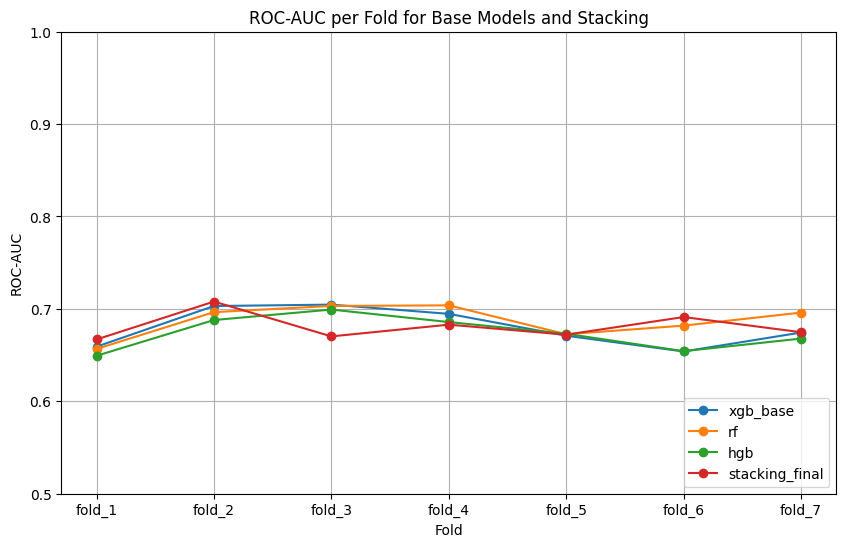

[train] Saved artifact to artifacts/model.joblib


In [11]:
X_train, y_train, X_test = crunch.load_data()
train(X_train, y_train, "artifacts")

In [12]:
preds = list(infer(X_test, "artifacts"))
print(preds[:10])


[None, 0.2400209903717041, 0.5164462924003601, 0.4314327836036682, 0.24189503490924835, 0.5060924887657166, 0.35595977306365967, 0.2447838932275772, 0.35414597392082214, 0.3289702534675598]


20:09:07 no forbidden library found
20:09:07 
20:09:07 started
20:09:07 running local test
20:09:07 internet access isn't restricted, no check will be done
20:09:07 
20:09:08 starting unstructured loop...
20:09:08 executing - command=train


data/X_train.parquet: download from https:crunchdao--competition--production.s3-accelerate.amazonaws.com/data-releases/146/X_train.parquet (204327238 bytes)
data/X_train.parquet: already exists, file length match
data/X_test.reduced.parquet: download from https:crunchdao--competition--production.s3-accelerate.amazonaws.com/data-releases/146/X_test.reduced.parquet (2380918 bytes)
data/X_test.reduced.parquet: already exists, file length match
data/y_train.parquet: download from https:crunchdao--competition--production.s3-accelerate.amazonaws.com/data-releases/146/y_train.parquet (61003 bytes)
data/y_train.parquet: already exists, file length match
data/y_test.reduced.parquet: download from https:crunchdao--competition--production.s3-accelerate.amazonaws.com/data-releases/146/y_test.reduced.parquet (2655 bytes)
data/y_test.reduced.parquet: already exists, file length match
[train] Features built: (10001, 29), labels: {0: 7092, 1: 2909}
[train] CV for base model: xgb_base
   fold 0 | xgb_b

2025-09-12 20:13:34.634526: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-09-12 20:13:34.634530: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-09-12 20:13:34.634534: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-09-12 20:13:34.634534: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757708014.878797    3005 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already b

[train] Stacking CV ROC-AUC: 0.6807 ± 0.0134


2025-09-12 20:27:17.747231: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757708837.791835    3265 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757708837.814109    3265 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


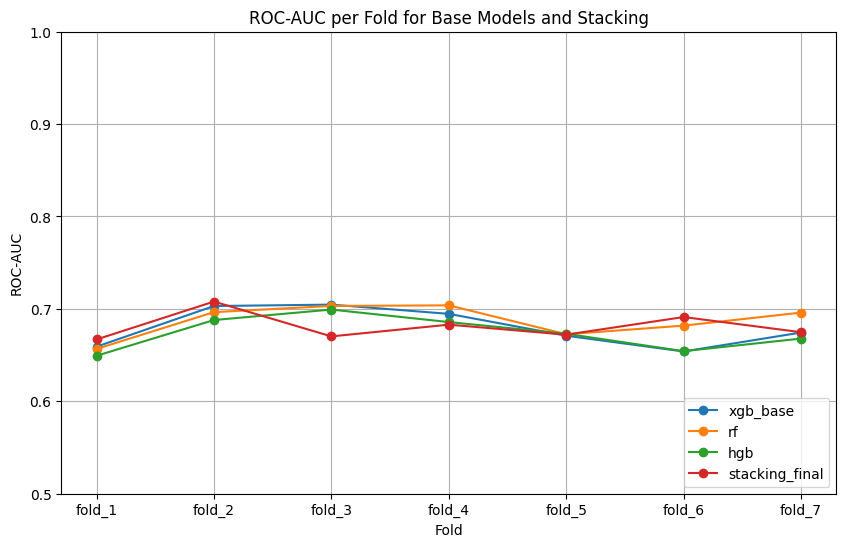

20:29:34 executing - command=infer


[train] Saved artifact to resources/model.joblib


20:30:08 checking determinism by executing the inference again with 30% of the data (tolerance: 1e-08)
20:30:08 executing - command=infer
20:30:19 determinism check: passed
20:30:19 save prediction - path=data/prediction.parquet
20:30:19 ended
20:30:19 duration - time=00:21:12
20:30:19 memory - before="1.57 GB" after="1.83 GB" consumed="259.42 MB"


In [13]:
crunch.test(
    # Uncomment to disable the train
    #force_first_train=False,

    # Uncomment to disable the determinism check
    # no_determinism_check=True,
)



In [14]:
prediction = pd.read_parquet("data/prediction.parquet")

prediction

,prediction
id,
10001,0.240021
10002,0.516446
10003,0.431433
10004,0.241895
10005,0.506092
...,...
10097,0.292724
10098,0.253744
10099,0.497288


In [15]:
# Load the targets
target = pd.read_parquet("data/y_test.reduced.parquet")["structural_breakpoint"]

# Call the scoring function
sklearn.metrics.roc_auc_score(
    target,
    prediction,
)

0.6295774647887324

In [16]:
target

id
10001    False
10002    False
10003    False
10004    False
10005    False
         ...  
10097    False
10098    False
10099    False
10100    False
10101    False
Name: structural_breakpoint, Length: 101, dtype: bool